In [1]:
### 常规分析包
import os
import time
import numpy as np
import pandas as pd
import scipy.stats as stats
from scipy.stats import norm, pearsonr, spearmanr
from scipy.spatial import distance
### 绘图包
import matplotlib.pyplot as plt
from matplotlib import gridspec
import matplotlib.lines as mlines
from matplotlib.font_manager import FontProperties
import matplotlib.dates as mdates
import seaborn as sns
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42 # 输出PDF文字可编辑
### 其他
import cloudpickle as pickle
import warnings
warnings.filterwarnings("ignore") # 报错提示
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all' #last_expr

In [2]:
sns.color_palette(["#4a4a4a", "#00798c", "#d1495b", '#edae49', '#66a182'])

[(0.2901960784313726, 0.2901960784313726, 0.2901960784313726),
 (0.0, 0.4745098039215686, 0.5490196078431373),
 (0.8196078431372549, 0.28627450980392155, 0.3568627450980392),
 (0.9294117647058824, 0.6823529411764706, 0.28627450980392155),
 (0.4, 0.6313725490196078, 0.5098039215686274)]

# 1. Accuaracy statistic

In [3]:
weights = [{ 
        'N_Species':100,
        'MEAN_WE':0.133,
        'MEAN_WA':0.133,
        'MEAN_WS':0.133,
        'MEAN_WN':0.6,
        'MEAN_WD':0.001,
        },
        { 
        'N_Species':100,
        'MEAN_WE':0.131,
        'MEAN_WA':0.132,
        'MEAN_WS':0.132,
        'MEAN_WN':0.6,
        'MEAN_WD':0.005,
        },
        { 
        'N_Species':100,
        'MEAN_WE':0.13,
        'MEAN_WA':0.13,
        'MEAN_WS':0.13,
        'MEAN_WN':0.6,
        'MEAN_WD':0.01,
        },
        { 
        'N_Species':100,
        'MEAN_WE':0.12,
        'MEAN_WA':0.13,
        'MEAN_WS':0.13,
        'MEAN_WN':0.6,
        'MEAN_WD':0.02,
        },
        { 
        'N_Species':100,
        'MEAN_WE':0.12,
        'MEAN_WA':0.12,
        'MEAN_WS':0.12,
        'MEAN_WN':0.6,
        'MEAN_WD':0.04,
        },
        { 
        'N_Species':100,
        'MEAN_WE':0.10,
        'MEAN_WA':0.12,
        'MEAN_WS':0.12,
        'MEAN_WN':0.6,
        'MEAN_WD':0.06,
        },
        { 
        'N_Species':100,
        'MEAN_WE':0.1,
        'MEAN_WA':0.1,
        'MEAN_WS':0.12,
        'MEAN_WN':0.6,
        'MEAN_WD':0.08,
        },
        { 
        'N_Species':100,
        'MEAN_WE':0.1,
        'MEAN_WA':0.1,
        'MEAN_WS':0.1,
        'MEAN_WN':0.6,
        'MEAN_WD':0.1,
        }]

import re
result = pd.DataFrame()
index = 0
for datasetid in range(1, 11):
    path = '../simuData/DiseaseWeight/DiseaseWeight'+str(datasetid)+'/'
    res = pd.DataFrame({'Dataset_ID':datasetid, 'Path':path, 'Difference_in_Metabolic_background':0.1}, 
                       index=['Dataset'+str(datasetid)+'W'+str(i) for i in range(1, 9)])
    # config
    res['Config_N_sample'] = 100
    res['Config_mean_env_trial0'] = 0.45
    res['Config_mean_env_trial1'] = 0.55
    res['Config_sigma_env_trial0'] = 0.2
    res['Config_sigma_env_trial1'] = 0.2
    res['Config_min_env'] = 0
    res['Config_max_env'] = 1
    res['Config_mean_age_trial0'] = 0.45
    res['Config_mean_age_trial1'] = 0.55
    res['Config_sigma_age_trial0'] = 0.2
    res['Config_sigma_age_trial1'] = 0.2
    res['Config_min_age'] = 0
    res['Config_max_age'] = 1
    res['Config_mean_sex_trial0'] = 0.45
    res['Config_mean_sex_trial1'] = 0.55
    res['Config_sigma_sex_trial0'] = 0.2
    res['Config_sigma_sex_trial1'] = 0.2
    res['Config_min_sex'] = 0
    res['Config_max_sex'] = 1
    res['Config_mean_noise'] = 0.5
    res['Config_sigma_noise'] = 0.2
    res['Config_min_noise'] = 0
    res['Config_max_noise'] = 1
    res['Config_trial_effect_env'] = 0.0
    res['Config_trial_effect_age'] = 0.0
    res['Config_trial_effect_sex'] = 0.0
    # caliper
    summary = ''.join(open(path+'/PSM_Summary_report.txt', 'r').readlines())
    caliper, ratio = re.search('caliper = ([\w\W]+?), ratio = ([\w\W]+?)\)', summary).groups()
    res['Caliper'] = caliper
    res['Ratio'] = ratio
    # Balance
    summary = pd.read_csv(path+'/Summary_of_Balance_for_All_Data.tsv', index_col=0, sep='\t')
    res['Balance_of_PS'] = summary.loc['distance', 'Std. Mean Diff.']
    # Pairs
    matched = pd.read_csv(path+'/PSM_Matched_Pairs.tsv', index_col=0, sep='\t')
    res['Pairs'] = matched.shape[0] - list(matched['V1']).count('NA_character_')
    # Weight of taxa & differential taxa
    diff = pd.read_csv(path+'/PSMresult.csv', index_col=0)
    diff['WeightGroup'] = [i[:2] for i in diff.index]
    for wid in range(len(weights)):
        index = 'Dataset'+str(datasetid)+'W'+str(wid+1)
        res.loc[index, 'Weight_ID'] = 'W'+str(wid+1)
        res.loc[index, 'Weight_env'] = weights[wid]['MEAN_WE']
        res.loc[index, 'Weight_age'] = weights[wid]['MEAN_WA']
        res.loc[index, 'Weight_sex'] = weights[wid]['MEAN_WS']
        res.loc[index, 'Weight_trail'] = weights[wid]['MEAN_WD']
        res.loc[index, 'Weight_noise'] = weights[wid]['MEAN_WN']
        res.loc[index, 'N_species'] = weights[wid]['N_Species']
        # differential taxa
        sub_diff = diff.loc[diff['WeightGroup']=='W'+str(wid+1), :]
        res.loc[index, 'Diff(raw)_by_p<0.05'] = sub_diff.loc[sub_diff['p-value(raw)']<0.05, :].shape[0]
        res.loc[index, 'Diff(PSM)_by_p<0.05'] = sub_diff.loc[sub_diff['p-value(PSM)']<0.05, :].shape[0]
        res.loc[index, 'Diff(raw)_by_fdr<0.05'] = sub_diff.loc[sub_diff['fdr(raw)']<0.05, :].shape[0]
        res.loc[index, 'Diff(PSM)_by_fdr<0.05'] = sub_diff.loc[sub_diff['fdr(PSM)']<0.05, :].shape[0]
        res.loc[index, "Diff(raw)_by_cohen's d>0.2"] = sub_diff.loc[sub_diff["cohen's d(raw)"]>0.2, :].shape[0]
        res.loc[index, "Diff(PSM)_by_cohen's d>0.2"] = sub_diff.loc[sub_diff["cohen's d(PSM)"]>0.2, :].shape[0]
        res.loc[index, "Diff(raw)_by_cohen's d>0.5"] = sub_diff.loc[sub_diff["cohen's d(raw)"]>0.5, :].shape[0]
        res.loc[index, "Diff(PSM)_by_cohen's d>0.5"] = sub_diff.loc[sub_diff["cohen's d(PSM)"]>0.5, :].shape[0]
    # concat
    result = pd.concat([result, res], axis=0, sort=False)
result.to_csv('../20230718_Results/Figure 2C. Simulated dataset.tsv', sep='\t')
result.head(2)

,Dataset_ID,Path,Difference_in_Metabolic_background,Config_N_sample,Config_mean_env_trial0,Config_mean_env_trial1,Config_sigma_env_trial0,Config_sigma_env_trial1,Config_min_env,Config_max_env,...,Weight_noise,N_species,Diff(raw)_by_p<0.05,Diff(PSM)_by_p<0.05,Diff(raw)_by_fdr<0.05,Diff(PSM)_by_fdr<0.05,Diff(raw)_by_cohen's d>0.2,Diff(PSM)_by_cohen's d>0.2,Diff(raw)_by_cohen's d>0.5,Diff(PSM)_by_cohen's d>0.5
Dataset1W1,1,../simuData/DiseaseWeight/DiseaseWeight1/,0.1,100,0.45,0.55,0.2,0.2,0,1,...,0.6,100.0,13.0,0.0,5.0,0.0,19.0,0.0,0.0,0.0
Dataset1W2,1,../simuData/DiseaseWeight/DiseaseWeight1/,0.1,100,0.45,0.55,0.2,0.2,0,1,...,0.6,100.0,31.0,0.0,18.0,0.0,37.0,0.0,0.0,0.0


# 2. Figure 2C

In [4]:
data = pd.read_csv('../20230718_Results/Figure 2C. Simulated dataset.tsv', sep='\t', index_col=0)
data.head(2)

,Dataset_ID,Path,Difference_in_Metabolic_background,Config_N_sample,Config_mean_env_trial0,Config_mean_env_trial1,Config_sigma_env_trial0,Config_sigma_env_trial1,Config_min_env,Config_max_env,...,Weight_noise,N_species,Diff(raw)_by_p<0.05,Diff(PSM)_by_p<0.05,Diff(raw)_by_fdr<0.05,Diff(PSM)_by_fdr<0.05,Diff(raw)_by_cohen's d>0.2,Diff(PSM)_by_cohen's d>0.2,Diff(raw)_by_cohen's d>0.5,Diff(PSM)_by_cohen's d>0.5
Dataset1W1,1,../simuData/DiseaseWeight/DiseaseWeight1/,0.1,100,0.45,0.55,0.2,0.2,0,1,...,0.6,100.0,13.0,0.0,5.0,0.0,19.0,0.0,0.0,0.0
Dataset1W2,1,../simuData/DiseaseWeight/DiseaseWeight1/,0.1,100,0.45,0.55,0.2,0.2,0,1,...,0.6,100.0,31.0,0.0,18.0,0.0,37.0,0.0,0.0,0.0


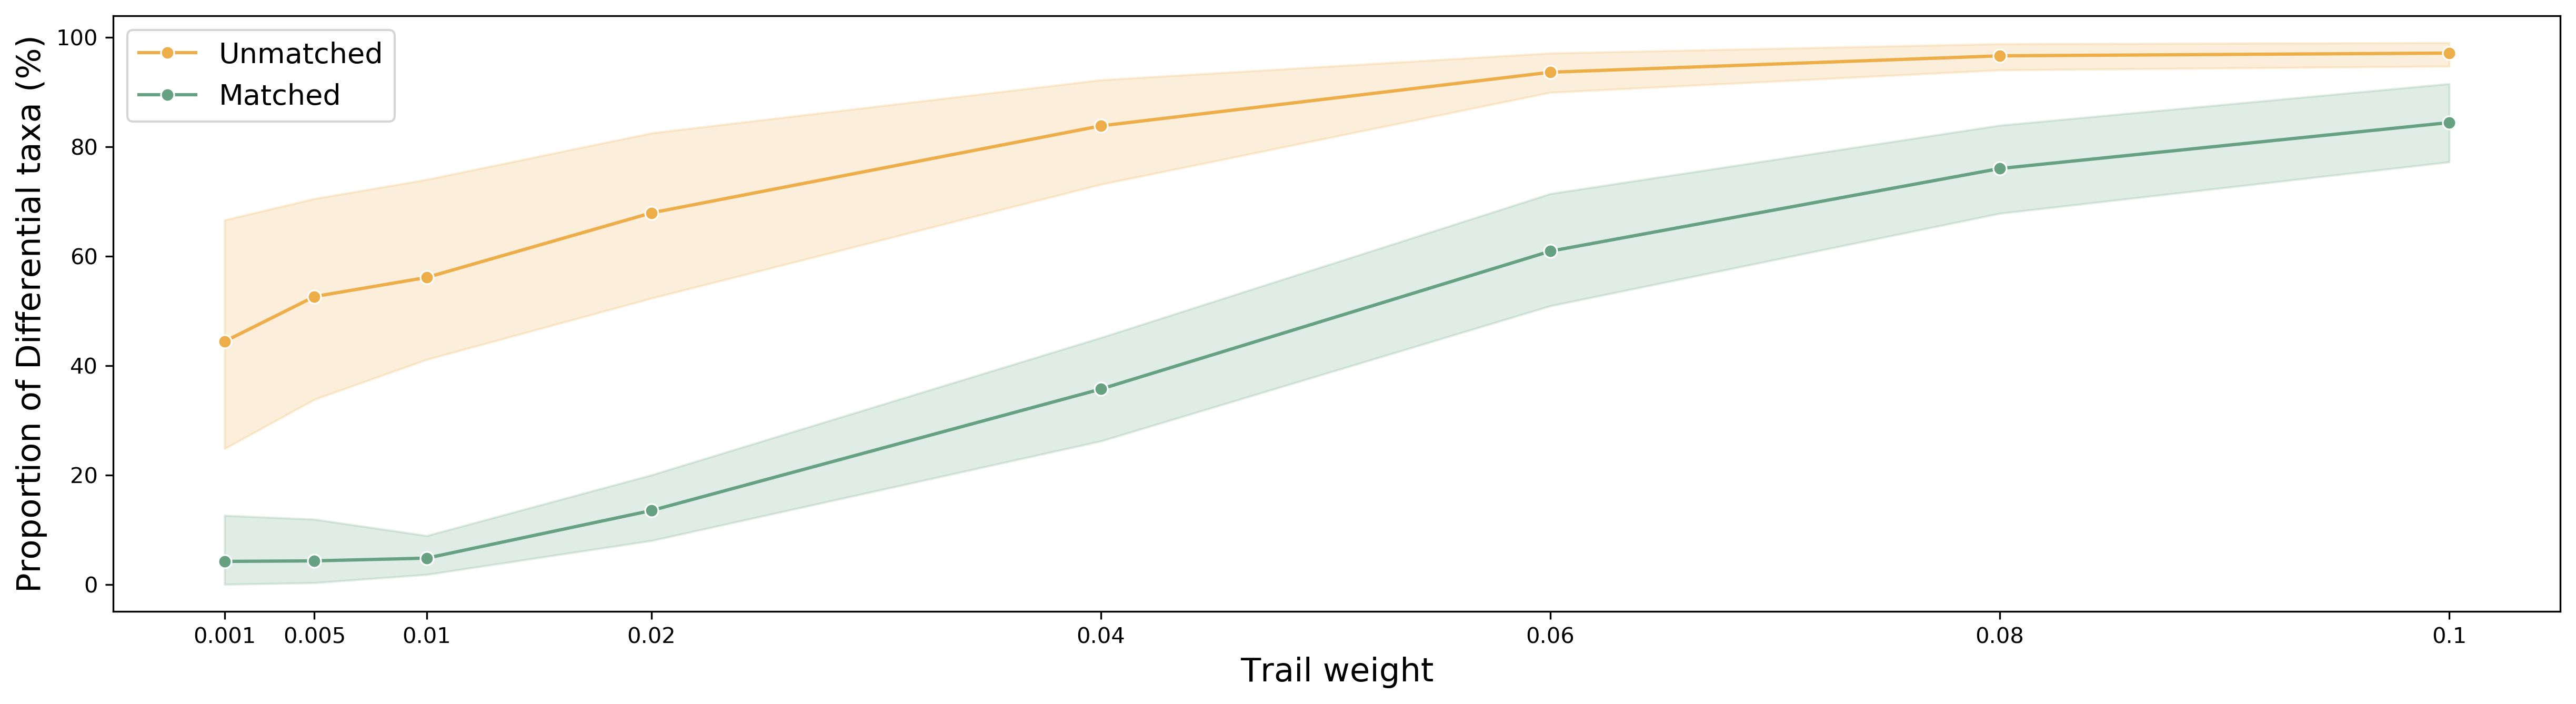

In [167]:
fig = plt.figure(figsize=(20, 5), dpi=300)
_ = sns.lineplot(x="Weight_trail", y="Diff(raw)_by_p<0.05", data=data, color='#edae49', marker='o', sort=False, label='Unmatched')
_ = sns.lineplot(x="Weight_trail", y="Diff(PSM)_by_p<0.05", data=data, color='#66a182', marker='o', sort=False, label='Matched')
_ = plt.xticks([0.001, 0.005, 0.01, 0.02, 0.04, 0.06, 0.08, 0.10], [0.001, 0.005, 0.01, 0.02, 0.04, 0.06, 0.08, 0.10])
_ = plt.xlabel('Trail weight', fontsize=15)
_ = plt.ylabel('Proportion of Differential taxa (%)', fontsize=15)
_ = plt.legend(fontsize=13)
_ = plt.show()
_ = fig.savefig('../20230718_Results/Figure 2C_Diff.pdf', dpi=300)

In [62]:
abun = pd.read_csv('../simuData/DiseaseWeight/DiseaseWeight1/microbiome.csv', index_col=0)
meta = pd.read_csv('../simuData/DiseaseWeight/DiseaseWeight1/metadata.csv', index_col=0)
diff = pd.read_csv('../simuData/DiseaseWeight/DiseaseWeight1/PSMresult.csv', index_col=0)
abun = pd.concat([abun, meta.iloc[:, :-2]], axis=1, sort=False)
abun.head(2)

,W1X0,W1X1,W1X2,W1X3,W1X4,W1X5,W1X6,W1X7,W1X8,W1X9,...,W8X95,W8X96,W8X97,W8X98,W8X99,Group,Environment,Age,Sex,Noise
s0,0.982225,1.482735,1.036219,0.914179,1.26744,1.461941,1.593865,1.55185,0.872358,1.127758,...,0.911536,1.594323,1.167952,1.063876,0.969554,0,0.283,0.368,0.562,0.845
s1,1.044585,1.573255,1.135399,1.041679,1.33252,1.553641,1.694145,1.63195,0.916678,1.202218,...,0.962096,1.673983,1.227232,1.113996,1.012174,0,0.647,0.535,0.593,0.856


In [87]:
def plot_ellipses(axis, x, y, std=1, facecolor='None', edgecolor='k', alpha=0.5, zorder=-10):
    '''
    # axis : axis of pyplot figure
    # x : values of x axis
    # y : values of y axis
    # return : ellipse plot of data
    #https://matplotlib.org/devdocs/gallery/statistics/confidence_ellipse.html
    '''
    from matplotlib.patches import Ellipse
    import matplotlib.transforms as transforms
    if x.size != y.size:
        raise ValueError("x and y must be the same size")
    cov = np.cov(x, y)
    pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0), width=ell_radius_x * 2, height=ell_radius_y * 2, facecolor=facecolor)
    scale_x = np.sqrt(cov[0, 0]) * std
    mean_x = np.mean(x)
    # calculating the stdandard deviation of y ...
    scale_y = np.sqrt(cov[1, 1]) * std
    mean_y = np.mean(y)
    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(mean_x, mean_y)
    ellipse.set_transform(transf + ax.transData)
    ellipse.set_facecolor(facecolor)
    ellipse.set_edgecolor(edgecolor)
    ellipse.set_alpha(alpha)
    ellipse.set_zorder(zorder)
    axis.add_artist(ellipse)
    return mean_x, mean_y, axis

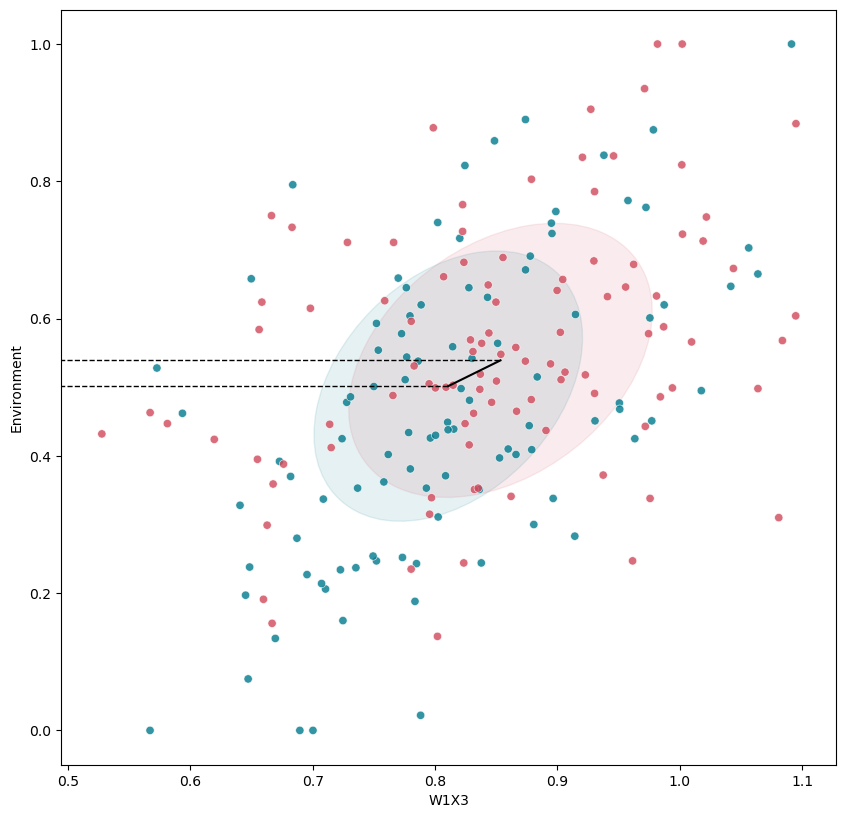

In [126]:
taxa = 'W1X3'

fig = plt.figure(figsize=(10, 10), dpi=100)
ax = plt.subplot(111)
_ = sns.scatterplot(x=taxa, y="Environment", hue='Group', data=abun, palette=["#00798c", "#d1495b"], alpha=0.8)
xlim_x, xlim_y = plt.xlim()

x1, y1, _ = plot_ellipses(ax, abun.loc[abun['Group']==0, taxa], abun.loc[abun['Group']==0, 'Age'], std=1.0, facecolor='#00798c', edgecolor='#00798c', alpha=0.1)
#_ = plt.scatter([x1], [y1], color='#00798c', marker='s')
#_ = plt.vlines(x=x, ymin=0.0, ymax=y)
_ = plt.hlines(y=y1, xmin=0, xmax=x1, ls='--', lw=1)
x2, y2, _ = plot_ellipses(ax, abun.loc[abun['Group']==1, taxa], abun.loc[abun['Group']==1, 'Age'], std=1.0, facecolor='#d1495b', edgecolor='#d1495b', alpha=0.1)
#_ = plt.scatter([x2], [y2], color='#d1495b', marker='s')
#_ = plt.vlines(x=x, ymin=0.0, ymax=y)
_ = plt.hlines(y=y2, xmin=0, xmax=x2, ls='--', lw=1)
_ = plt.plot([x1, x2], [y1, y2], 'k-')
_ = plt.xlim(xlim_x, xlim_y)
_ = plt.ylim(-0.05, 1.05)
ax.legend_ = None

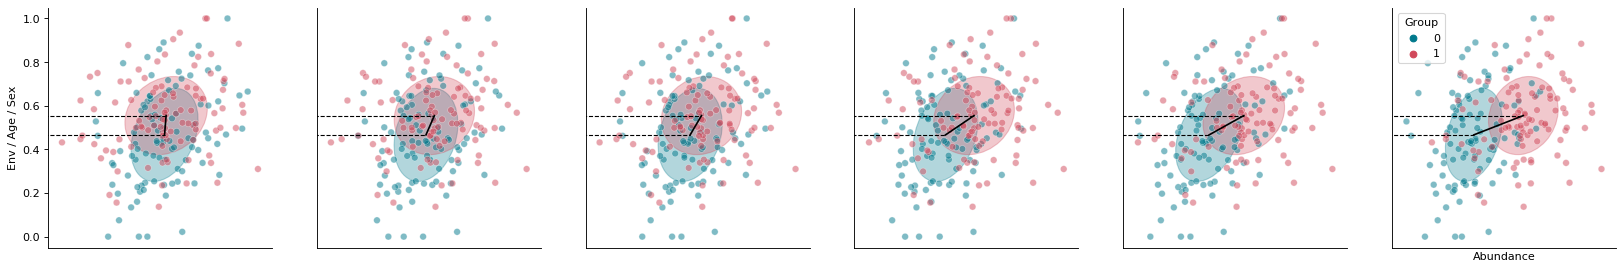

In [165]:
fig = plt.figure(figsize=(20, 3), dpi=80)
size = 5
gs = gridspec.GridSpec(1, 6, left=0.01, right=0.99, top=1, bottom=0.0, wspace=0.2, hspace=0.1)

tid = '14'

ax = plt.subplot(gs[:, 0])
taxa = 'W1X'+tid
_ = sns.scatterplot(x=taxa, y="Environment", hue='Group', data=abun, palette=["#00798c", "#d1495b"], alpha=0.5)
xlim_x, xlim_y = plt.xlim()
x1, y1, _ = plot_ellipses(ax, abun.loc[abun['Group']==0, taxa], abun.loc[abun['Group']==0, 'Environment'], std=1.0, facecolor='#00798c', edgecolor='#00798c', alpha=0.3)
_ = plt.hlines(y=y1, xmin=0, xmax=x1, ls='--', lw=1)
x2, y2, _ = plot_ellipses(ax, abun.loc[abun['Group']==1, taxa], abun.loc[abun['Group']==1, 'Environment'], std=1.0, facecolor='#d1495b', edgecolor='#d1495b', alpha=0.3)
_ = plt.hlines(y=y2, xmin=0, xmax=x2, ls='--', lw=1)
_ = plt.plot([x1, x2], [y1, y2], 'k-')
_ = plt.xlim(xlim_x, xlim_y)
_ = plt.ylim(-0.05, 1.05)
ax.legend_ = None
_ = ax.spines['top'].set_visible(False)
_ = ax.spines['right'].set_visible(False)
_ = ax.set_ylabel('Env / Age / Sex')
_ = ax.set_xlabel('')
_ = ax.set_xticks([])

ax = plt.subplot(gs[:, 1])
taxa = 'W4X'+tid
_ = sns.scatterplot(x=taxa, y="Environment", hue='Group', data=abun, palette=["#00798c", "#d1495b"], alpha=0.5)
xlim_x, xlim_y = plt.xlim()
x1, y1, _ = plot_ellipses(ax, abun.loc[abun['Group']==0, taxa], abun.loc[abun['Group']==0, 'Environment'], std=1.0, facecolor='#00798c', edgecolor='#00798c', alpha=0.3)
_ = plt.hlines(y=y1, xmin=0, xmax=x1, ls='--', lw=1)
x2, y2, _ = plot_ellipses(ax, abun.loc[abun['Group']==1, taxa], abun.loc[abun['Group']==1, 'Environment'], std=1.0, facecolor='#d1495b', edgecolor='#d1495b', alpha=0.3)
_ = plt.hlines(y=y2, xmin=0, xmax=x2, ls='--', lw=1)
_ = plt.plot([x1, x2], [y1, y2], 'k-')
_ = plt.xlim(xlim_x, xlim_y)
_ = plt.ylim(-0.05, 1.05)
_ = ax.legend_ = None
_ = ax.spines['top'].set_visible(False)
_ = ax.spines['right'].set_visible(False)
_ = ax.set_ylabel('Env / Age / Sex')
_ = ax.set_xlabel('')
_ = ax.set_xticks([])
_ = ax.get_yaxis().set_visible(False)

ax = plt.subplot(gs[:, 2])
taxa = 'W5X'+tid
_ = sns.scatterplot(x=taxa, y="Environment", hue='Group', data=abun, palette=["#00798c", "#d1495b"], alpha=0.5)
xlim_x, xlim_y = plt.xlim()
x1, y1, _ = plot_ellipses(ax, abun.loc[abun['Group']==0, taxa], abun.loc[abun['Group']==0, 'Environment'], std=1.0, facecolor='#00798c', edgecolor='#00798c', alpha=0.3)
_ = plt.hlines(y=y1, xmin=0, xmax=x1, ls='--', lw=1)
x2, y2, _ = plot_ellipses(ax, abun.loc[abun['Group']==1, taxa], abun.loc[abun['Group']==1, 'Environment'], std=1.0, facecolor='#d1495b', edgecolor='#d1495b', alpha=0.3)
_ = plt.hlines(y=y2, xmin=0, xmax=x2, ls='--', lw=1)
_ = plt.plot([x1, x2], [y1, y2], 'k-')
_ = plt.xlim(xlim_x, xlim_y)
_ = plt.ylim(-0.05, 1.05)
_ = ax.legend_ = None
_ = ax.spines['top'].set_visible(False)
_ = ax.spines['right'].set_visible(False)
_ = ax.set_ylabel('Env / Age / Sex')
_ = ax.set_xlabel('')
_ = ax.set_xticks([])
_ = ax.get_yaxis().set_visible(False)

ax = plt.subplot(gs[:, 3])
taxa = 'W6X'+tid
_ = sns.scatterplot(x=taxa, y="Environment", hue='Group', data=abun, palette=["#00798c", "#d1495b"], alpha=0.5)
xlim_x, xlim_y = plt.xlim()
x1, y1, _ = plot_ellipses(ax, abun.loc[abun['Group']==0, taxa], abun.loc[abun['Group']==0, 'Environment'], std=1.0, facecolor='#00798c', edgecolor='#00798c', alpha=0.3)
_ = plt.hlines(y=y1, xmin=0, xmax=x1, ls='--', lw=1)
x2, y2, _ = plot_ellipses(ax, abun.loc[abun['Group']==1, taxa], abun.loc[abun['Group']==1, 'Environment'], std=1.0, facecolor='#d1495b', edgecolor='#d1495b', alpha=0.3)
_ = plt.hlines(y=y2, xmin=0, xmax=x2, ls='--', lw=1)
_ = plt.plot([x1, x2], [y1, y2], 'k-')
_ = plt.xlim(xlim_x, xlim_y)
_ = plt.ylim(-0.05, 1.05)
_ = ax.legend_ = None
_ = ax.spines['top'].set_visible(False)
_ = ax.spines['right'].set_visible(False)
_ = ax.set_ylabel('Env / Age / Sex')
_ = ax.set_xlabel('')
_ = ax.set_xticks([])
_ = ax.get_yaxis().set_visible(False)

ax = plt.subplot(gs[:, 4])
taxa = 'W7X0'
_ = sns.scatterplot(x=taxa, y="Environment", hue='Group', data=abun, palette=["#00798c", "#d1495b"], alpha=0.5)
xlim_x, xlim_y = plt.xlim()
x1, y1, _ = plot_ellipses(ax, abun.loc[abun['Group']==0, taxa], abun.loc[abun['Group']==0, 'Environment'], std=1.0, facecolor='#00798c', edgecolor='#00798c', alpha=0.3)
_ = plt.hlines(y=y1, xmin=0, xmax=x1, ls='--', lw=1)
x2, y2, _ = plot_ellipses(ax, abun.loc[abun['Group']==1, taxa], abun.loc[abun['Group']==1, 'Environment'], std=1.0, facecolor='#d1495b', edgecolor='#d1495b', alpha=0.3)
_ = plt.hlines(y=y2, xmin=0, xmax=x2, ls='--', lw=1)
_ = plt.plot([x1, x2], [y1, y2], 'k-')
_ = plt.xlim(xlim_x, xlim_y)
_ = plt.ylim(-0.05, 1.05)
_ = ax.legend_ = None
_ = ax.spines['top'].set_visible(False)
_ = ax.spines['right'].set_visible(False)
_ = ax.set_ylabel('Env / Age / Sex')
_ = ax.set_xlabel('')
_ = ax.set_xticks([])
_ = ax.get_yaxis().set_visible(False)

ax = plt.subplot(gs[:, 5])
taxa = 'W8X'+tid
_ = sns.scatterplot(x=taxa, y="Environment", hue='Group', data=abun, palette=["#00798c", "#d1495b"], alpha=0.5)
xlim_x, xlim_y = plt.xlim()
x1, y1, _ = plot_ellipses(ax, abun.loc[abun['Group']==0, taxa], abun.loc[abun['Group']==0, 'Environment'], std=1.0, facecolor='#00798c', edgecolor='#00798c', alpha=0.3)
_ = plt.hlines(y=y1, xmin=0, xmax=x1, ls='--', lw=1)
x2, y2, _ = plot_ellipses(ax, abun.loc[abun['Group']==1, taxa], abun.loc[abun['Group']==1, 'Environment'], std=1.0, facecolor='#d1495b', edgecolor='#d1495b', alpha=0.3)
_ = plt.hlines(y=y2, xmin=0, xmax=x2, ls='--', lw=1)
_ = plt.plot([x1, x2], [y1, y2], 'k-')
_ = plt.xlim(xlim_x, xlim_y)
_ = plt.ylim(-0.05, 1.05)
_ = ax.get_yaxis().set_visible(False)
_ = ax.spines['top'].set_visible(False)
_ = ax.spines['right'].set_visible(False)
_ = ax.set_ylabel('Env / Age / Sex')
_ = ax.set_xlabel('Abundance')
_ = ax.set_xticks([])

_ = fig.savefig('../20230718_Results/Figure 2C_Scatter.pdf', dpi=300)

# 3. Figure S4

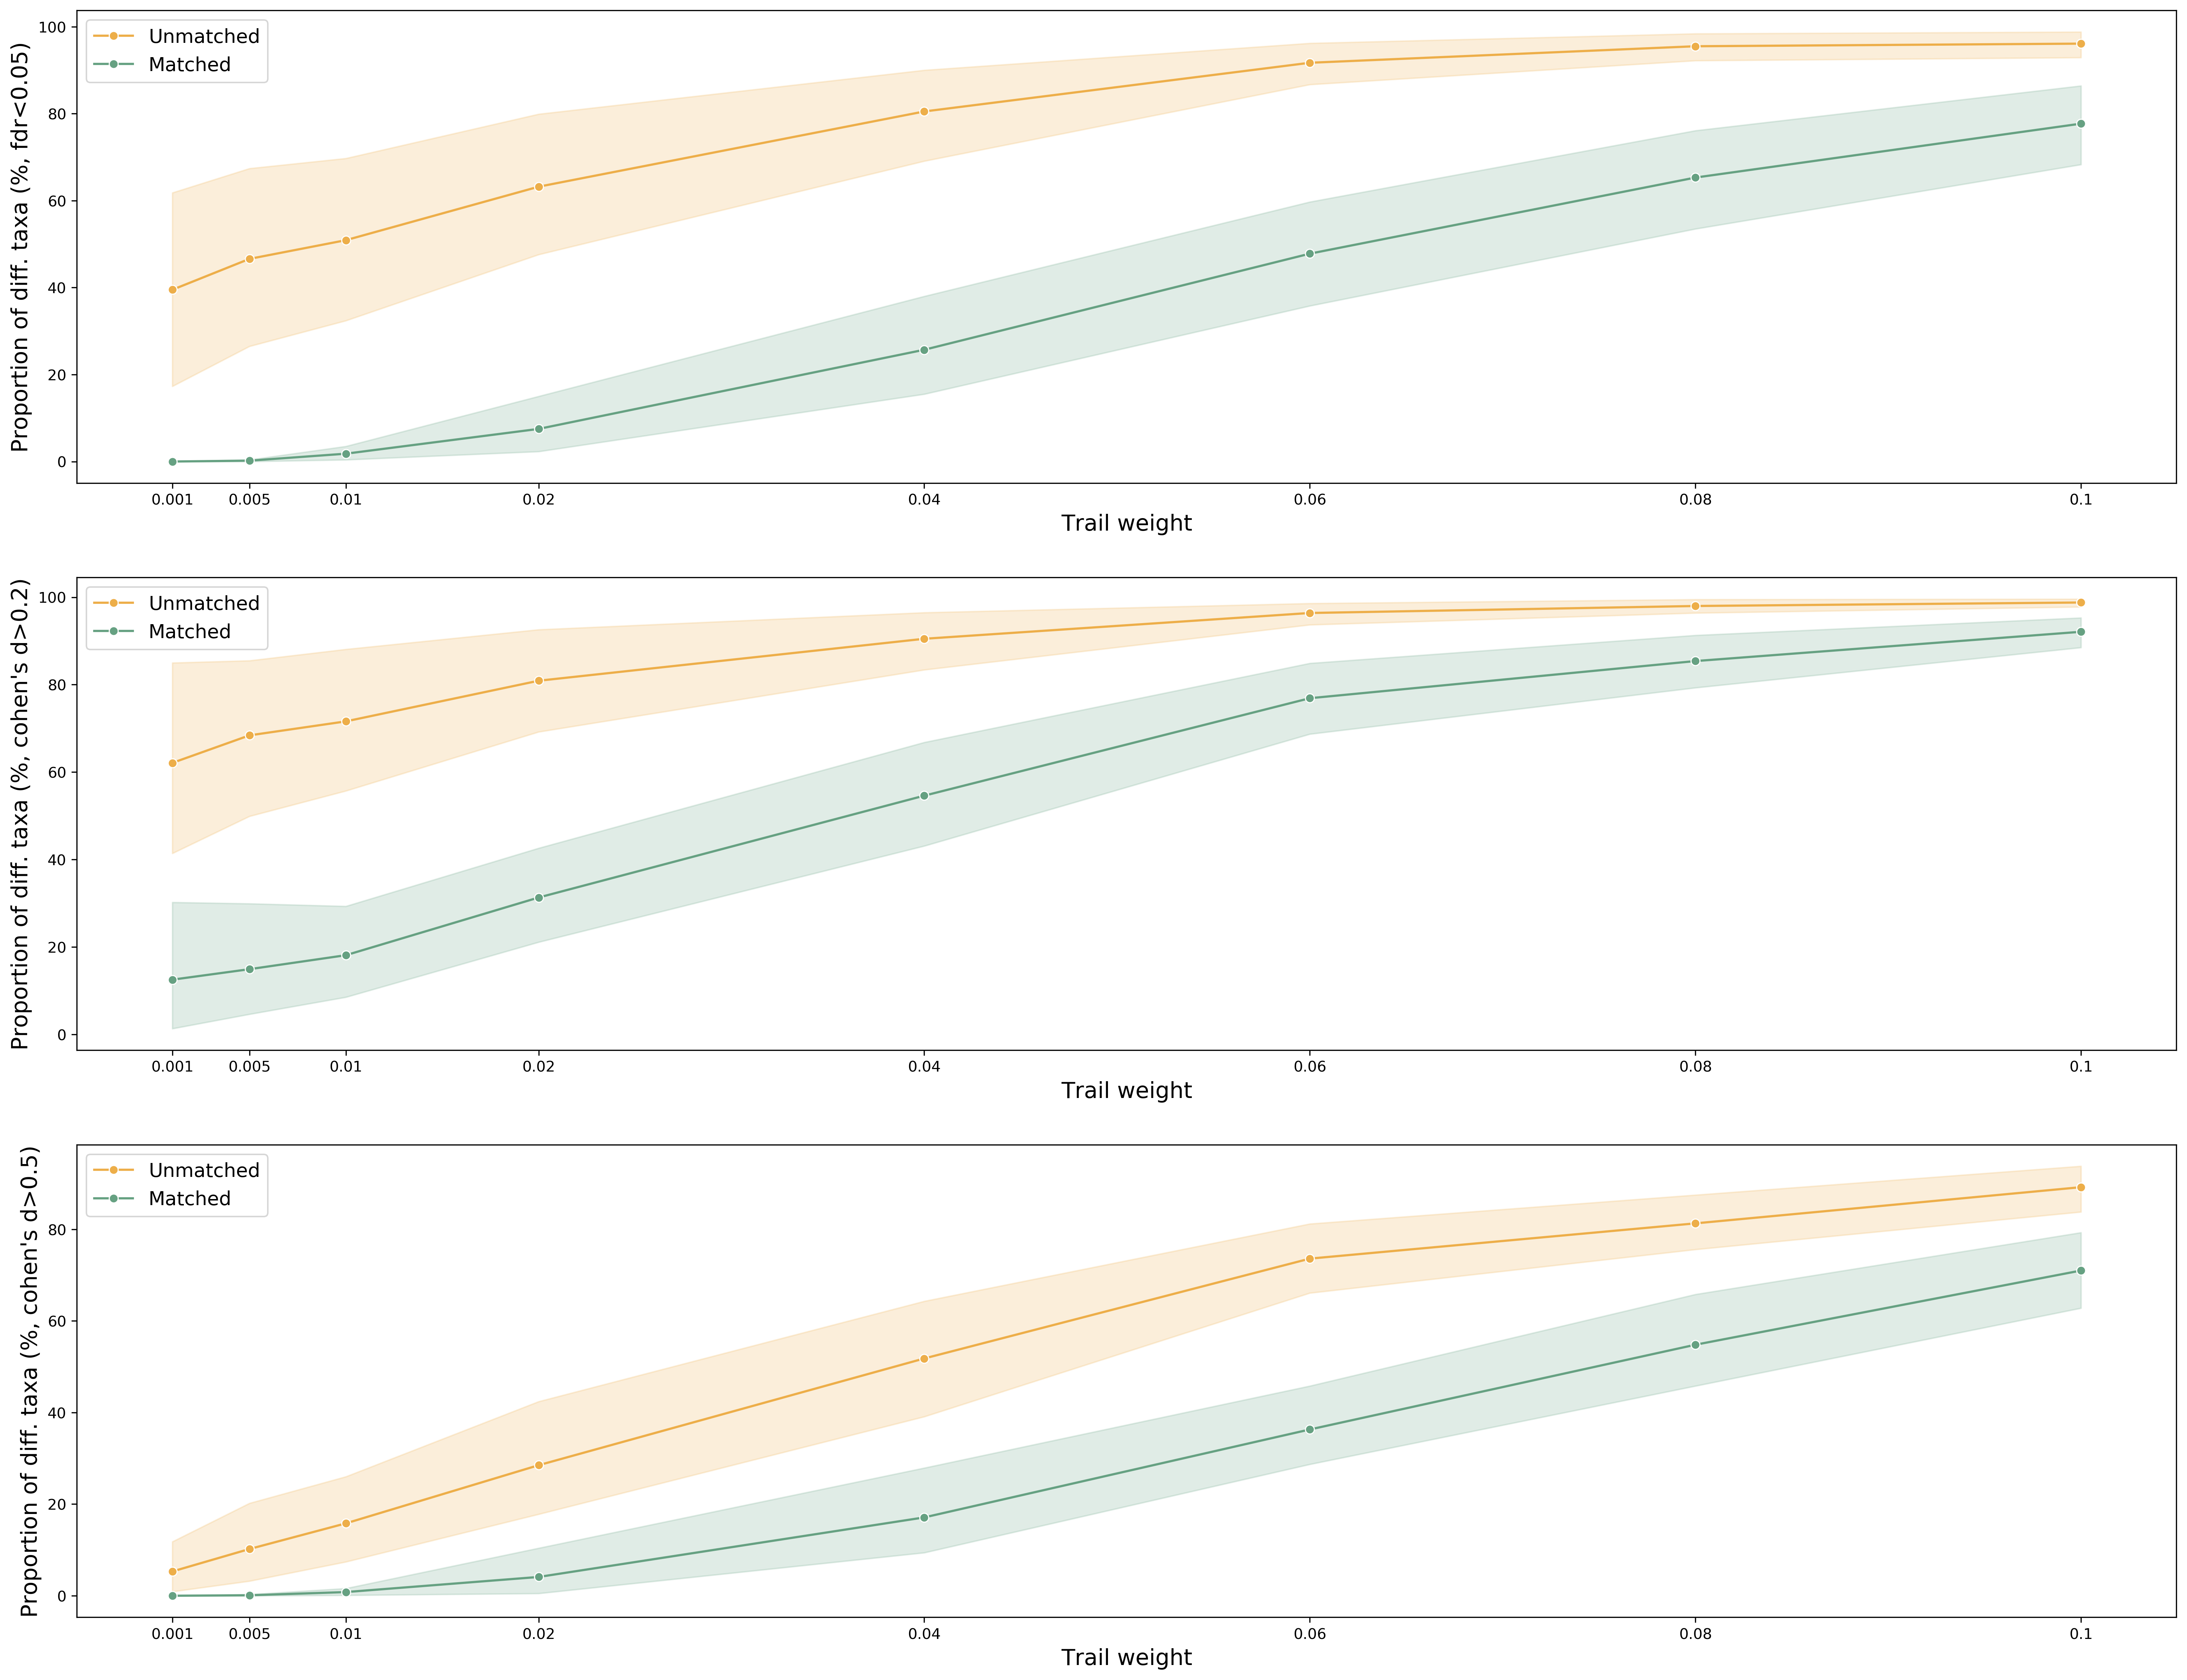

In [171]:
fig = plt.figure(figsize=(20, 15), dpi=300)
gs = gridspec.GridSpec(3, 1, left=0.01, right=0.99, top=1, bottom=0.0, wspace=0.0, hspace=0.2)

ax1 = plt.subplot(gs[0, 0])
_ = sns.lineplot(x="Weight_trail", y="Diff(raw)_by_fdr<0.05", data=data, color='#edae49', marker='o', sort=False, label='Unmatched')
_ = sns.lineplot(x="Weight_trail", y="Diff(PSM)_by_fdr<0.05", data=data, color='#66a182', marker='o', sort=False, label='Matched')
_ = plt.xticks([0.001, 0.005, 0.01, 0.02, 0.04, 0.06, 0.08, 0.10], [0.001, 0.005, 0.01, 0.02, 0.04, 0.06, 0.08, 0.10])
_ = plt.xlabel('Trail weight', fontsize=15)
_ = plt.ylabel('Proportion of diff. taxa (%, fdr<0.05)', fontsize=15)
_ = plt.legend(fontsize=13)

ax2 = plt.subplot(gs[1, 0])
_ = sns.lineplot(x="Weight_trail", y="Diff(raw)_by_cohen's d>0.2", data=data, color='#edae49', marker='o', sort=False, label='Unmatched')
_ = sns.lineplot(x="Weight_trail", y="Diff(PSM)_by_cohen's d>0.2", data=data, color='#66a182', marker='o', sort=False, label='Matched')
_ = plt.xticks([0.001, 0.005, 0.01, 0.02, 0.04, 0.06, 0.08, 0.10], [0.001, 0.005, 0.01, 0.02, 0.04, 0.06, 0.08, 0.10])
_ = plt.xlabel('Trail weight', fontsize=15)
_ = plt.ylabel("Proportion of diff. taxa (%, cohen's d>0.2)", fontsize=15)
_ = plt.legend(fontsize=13)

ax3 = plt.subplot(gs[2, 0])
_ = sns.lineplot(x="Weight_trail", y="Diff(raw)_by_cohen's d>0.5", data=data, color='#edae49', marker='o', sort=False, label='Unmatched')
_ = sns.lineplot(x="Weight_trail", y="Diff(PSM)_by_cohen's d>0.5", data=data, color='#66a182', marker='o', sort=False, label='Matched')
_ = plt.xticks([0.001, 0.005, 0.01, 0.02, 0.04, 0.06, 0.08, 0.10], [0.001, 0.005, 0.01, 0.02, 0.04, 0.06, 0.08, 0.10])
_ = plt.xlabel('Trail weight', fontsize=15)
_ = plt.ylabel("Proportion of diff. taxa (%, cohen's d>0.5)", fontsize=15)
_ = plt.legend(fontsize=13)
_ = plt.show()

_ = fig.savefig('../20230718_Results/Figure S4.pdf', dpi=300)